In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 14 14:16:04 2020

@author: thomas
"""

#MODULES
import os,sys
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
%matplotlib notebook
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
from scipy.signal import savgol_filter
import pathlib
from matplotlib import animation
from IPython.display import display, Image, HTML

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally

In [10]:
#CONSTANTS
cwd_PYTHON = os.getcwd()
PERIOD = 0.1
DT = 1.0e-2
RADIUSLARGE = 0.002
RADIUSSMALL = 0.001

#Lists
#RLength
R = ["3","5","6","7"]
SwimDirList = ["SSL", "LSL", "Stat"]

allData = []

In [11]:
def StoreData(strR,strTheta, strConfig, strRe):
    #global axAll
    #Reset position data every Re
    pdData = []
    #Load position data
    #Periodic
    pdData = pd.read_csv(cwd_PYTHON+'/../Periodic/'+strR+'/'+strTheta+'/'+strConfig+'/'+strRe+'/pd.txt',delimiter = ' ')
    #Save only every 10 rows (Every period)
    pdData = pdData.iloc[::10]
    #Reindex so index corresponds to period number
    pdData = pdData.reset_index(drop=True)
    #Create CM variables
    pdData['aXCM'] = 0.8*pdData.aXU + 0.2*pdData.aXL
    pdData['aYCM'] = 0.8*pdData.aYU + 0.2*pdData.aYL
    pdData['bXCM'] = 0.8*pdData.bXU + 0.2*pdData.bXL
    pdData['bYCM'] = 0.8*pdData.bYU + 0.2*pdData.bYL
    #Find separation distance and relative heading for LS
    pdData['H'], pdData['Theta'] = FindDistAngleBW(pdData['aXU'],pdData['aYU'],
                                                     pdData['bXU'],pdData['bYU'],
                                                     pdData['aXL'],pdData['aYL'],
                                                     pdData['bXL'],pdData['bYL'])
    #Calculate deltaH and deltaTheta
    pdData['dH'] = CalcDelta(pdData['H'])
    pdData['dTheta'] = CalcDelta(pdData['Theta'])
    
    '''#Plot distBW vs time and angleBW vs time
    PlotHTheta(pdData['H'],pdData['Theta'],pdData['dH'],pdData['dTheta'],
               pdData['time'],strR,strTheta,strConfig,strRe)'''
    
    #PlotAllHTheta(pdData['H'],pdData['Theta'],pdData['dH'],pdData['dTheta'],pdData['time'])
    
    return pdData

In [12]:
def FindDistAngleBW(aXU,aYU,bXU,bYU,aXL,aYL,bXL,bYL):
    #Find Distance b/w the 2 swimmers (Large Spheres)
    distXU = bXU - aXU
    distYU = bYU - aYU
    distBW = np.hypot(distXU,distYU)
    #Find relative heading Theta (angle formed by 2 swimmers)
    #1) Find normal orientation for swimmer A
    dist_aX = aXU - aXL
    dist_aY = aYU - aYL
    dist_a = np.hypot(dist_aX,dist_aY)
    norm_aX, norm_aY = dist_aX/dist_a, dist_aY/dist_a
    #Find normal orientation for swimmer B
    dist_bX = bXU - bXL
    dist_bY = bYU - bYL
    dist_b = np.hypot(dist_bX,dist_bY)
    norm_bX, norm_bY = dist_bX/dist_b, dist_bY/dist_b
    #2) Calculate Theta_a
    Theta_a = np.zeros(len(norm_aX))
    for idx in range(len(norm_aX)):
        if(norm_aY[idx] >= 0.0):
            Theta_a[idx] = np.arccos(norm_aX[idx])
        else:
            Theta_a[idx] = -1.0*np.arccos(norm_aX[idx])+2.0*np.pi
    #print('Theta_a = ',Theta_a*180.0/np.pi)
    #3) Rotate A and B ccw by 2pi - Theta_a
    Angle = 2.0*np.pi - Theta_a
    #print('Angle = ',Angle*180.0/np.pi)
    #Create rotation matrix
    rotationMatrix = np.zeros((len(Angle),2,2))
    rotationMatrix[:,0,0] = np.cos(Angle)
    rotationMatrix[:,0,1] = -1.0*np.sin(Angle)
    rotationMatrix[:,1,0] = np.sin(Angle)
    rotationMatrix[:,1,1] = np.cos(Angle)
    #print('rotationMatrix[-1] = ',rotationMatrix[10,:,:])
    #Create swimmer position arrays
    pos_a = np.zeros((len(norm_aX),2))
    pos_b = np.zeros((len(norm_bX),2))
    pos_a[:,0],pos_a[:,1] = norm_aX,norm_aY
    pos_b[:,0],pos_b[:,1] = norm_bX,norm_bY
    #print('pos_a = ',pos_a)
    #print('pos_b = ',pos_b)
    #Apply rotation operator
    rotpos_a, rotpos_b = np.zeros((len(norm_aX),2)), np.zeros((len(norm_bX),2))
    for idx in range(len(norm_aX)):
        #print('pos_a = ',pos_a[idx,:])
        #print('pos_b = ',pos_b[idx,:])
        #print('rotationMatrix = ',rotationMatrix[idx])
        rotpos_a[idx,:] = rotationMatrix[idx,:,:].dot(pos_a[idx,:])
        rotpos_b[idx,:] = rotationMatrix[idx,:,:].dot(pos_b[idx,:])
        #print('rotpos_a = ',rotpos_a[idx,:])
        #print('rotpos_b = ',rotpos_b[idx,:])
    #print('rotpos_a = ',rotpos_a)
    #print('rotpos_b = ',rotpos_b)
    #Calculate angleBW
    angleBW = np.zeros(len(norm_bY))
    for idx in range(len(norm_bY)):
        #angleBW[idx] = np.arccos(rotpos_a[idx,:].dot(rotpos_b[idx,:]))
        if(rotpos_b[idx,1] >= 0.0):
            angleBW[idx] = np.arccos(rotpos_a[idx,:].dot(rotpos_b[idx,:]))
        else:
            angleBW[idx] = -1.0*np.arccos(rotpos_a[idx,:].dot(rotpos_b[idx,:]))+2.0*np.pi
        
    #print('angleBW = ',angleBW*180/np.pi)
    
    return (distBW, angleBW)

In [13]:
def CalcDelta(data):
    #Calculate the change in either H or Theta for every period
    delta = data.copy()
    delta[0] = 0.0
    for idxPer in range(1,len(delta)):
        delta[idxPer] = data[idxPer] - data[idxPer-1]
        
    return delta

In [14]:
if __name__ == '__main__':
    
    #dirsVisc = [d for d in os.listdir(cwd_STRUCT) if os.path.isdir(d)]
    #The main goal of this script is to create an H-Theta Phase Space of all
    #simulations for every period elapsed.
    #Example: 20s of sim time = 200 periods. 200 H-Theta Plots
    #We may find that we can combine the H-Theta data after steady state has been reached
    #1) For each simulation, store position data for every period (nothing in between)
    #2) Calculate separation distance between large spheres (H)
    #3) Calculate relative heading (Theta)
    #4) Calculate deltaH and deltaTheta (change after one Period)
    #5) Plot H vs Theta (Polar) for each period

    count = 0
    for idxR in range(len(R)):
        cwd_R = cwd_PYTHON + '/../Periodic/' + R[idxR]
        dirsTheta = [d for d in os.listdir(cwd_R) if not d.startswith('.')]
        for Theta in dirsTheta:
            cwd_THETA = cwd_R + '/' + Theta
            dirsConfig = [d for d in os.listdir(cwd_THETA) if not d.startswith('.')]
            for Config in dirsConfig:
                for idxRe in range(len(SwimDirList)):
                    if(idxRe == 2):
                        count += 1
    print('count = ',count)
    
    allData = [[[] for a in range(count)] for b in range(len(SwimDirList))] #[None]*(count)
    
    #For each Reynolds number (aka Swim Direction)
    for idxRe in range(len(SwimDirList)):
        count = 0
        #For each Initial Separation Distance
        #H(0) = Rval*R; R = radius of large sphere = 0.002m = 2mm
        for idxR in range(len(R)):
            cwd_R = cwd_PYTHON + '/../Periodic/' + R[idxR]
            #For each orientation at the specified length
            dirsTheta = [d for d in os.listdir(cwd_R) if not d.startswith('.')]
            for Theta in dirsTheta:
                cwd_THETA = cwd_R + '/' + Theta
                #For each configuration
                dirsConfig = [d for d in os.listdir(cwd_THETA) if not d.startswith('.')]
                for Config in dirsConfig:
                    print(R[idxR]+'\t'+Theta+'\t'+Config)
                    allData[idxRe][count] = StoreData(R[idxR],Theta,Config,SwimDirList[idxRe])
                    count += 1        

count =  74
3	PI1	Anti
3	PI1	Parallel
3	PI1	PerpL
3	PI1	PerpS
3	PI2	Anti
3	PI2	Parallel
3	PI2	PerpL
3	PI2	PerpS
3	PI3	Anti
3	PI3	Parallel
3	PI3	PerpL
3	PI3	PerpS
3	PI4	PerpL
3	PI4	PerpS
5	PI0	Anti
5	PI0	Parallel
5	PI0	PerpL
5	PI0	PerpS
5	PI1	Anti
5	PI1	Parallel
5	PI1	PerpL
5	PI1	PerpS
5	PI2	Anti
5	PI2	Parallel
5	PI2	PerpL
5	PI2	PerpS
5	PI3	Anti
5	PI3	Parallel
5	PI3	PerpL
5	PI3	PerpS
5	PI4	Anti
5	PI4	Parallel
5	PI4	PerpL
5	PI4	PerpS
6	PI0	Anti
6	PI0	Parallel
6	PI0	PerpL
6	PI0	PerpS
6	PI1	Anti
6	PI1	Parallel
6	PI1	PerpL
6	PI1	PerpS
6	PI2	Anti
6	PI2	Parallel
6	PI2	PerpL
6	PI2	PerpS
6	PI3	Anti
6	PI3	Parallel
6	PI3	PerpL
6	PI3	PerpS
6	PI4	Anti
6	PI4	Parallel
6	PI4	PerpL
6	PI4	PerpS
7	PI0	Anti
7	PI0	Parallel
7	PI0	PerpL
7	PI0	PerpS
7	PI1	Anti
7	PI1	Parallel
7	PI1	PerpL
7	PI1	PerpS
7	PI2	Anti
7	PI2	Parallel
7	PI2	PerpL
7	PI2	PerpS
7	PI3	Anti
7	PI3	Parallel
7	PI3	PerpL
7	PI3	PerpS
7	PI4	Anti
7	PI4	Parallel
7	PI4	PerpL
7	PI4	PerpS
3	PI1	Anti
3	PI1	Parallel
3	PI1	PerpL
3	PI1	PerpS
3	PI2	Anti
3	P

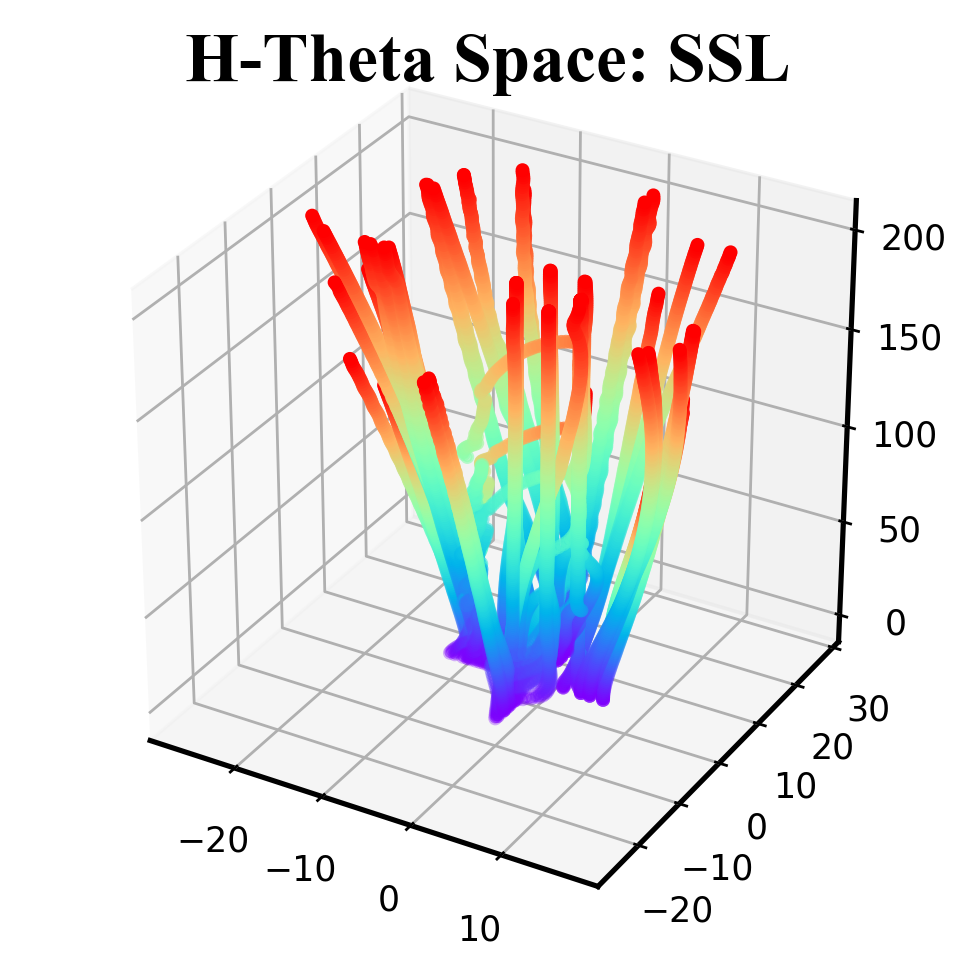

/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/Rotated/SSL
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.0.0 (clang-900.0.39.2)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --arch=x86_64 --enable-x86asm --enable-libx265 --enable-gpl --ena

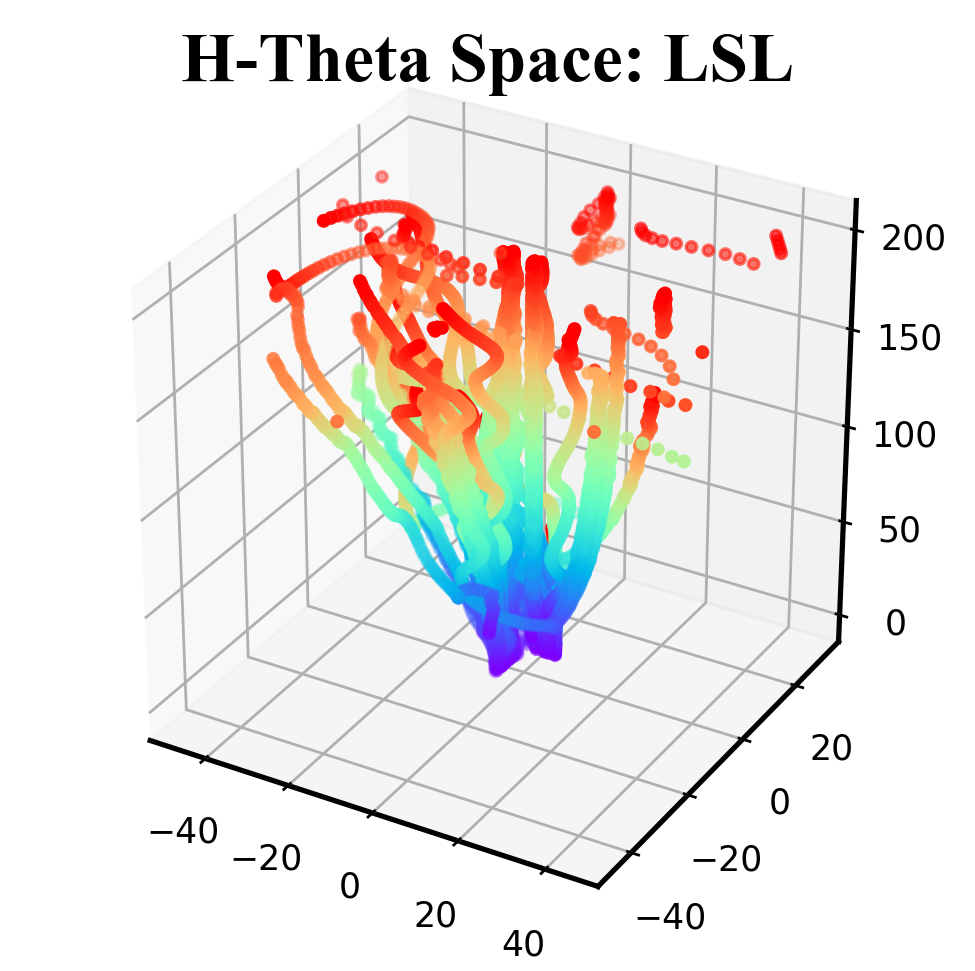

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.0.0 (clang-900.0.39.2)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --arch=x86_64 --enable-x86asm --enable-libx265 --enable-gpl --enable-postproc --enable-libx264 --enable-libxvid
  libavutil      56. 14.100

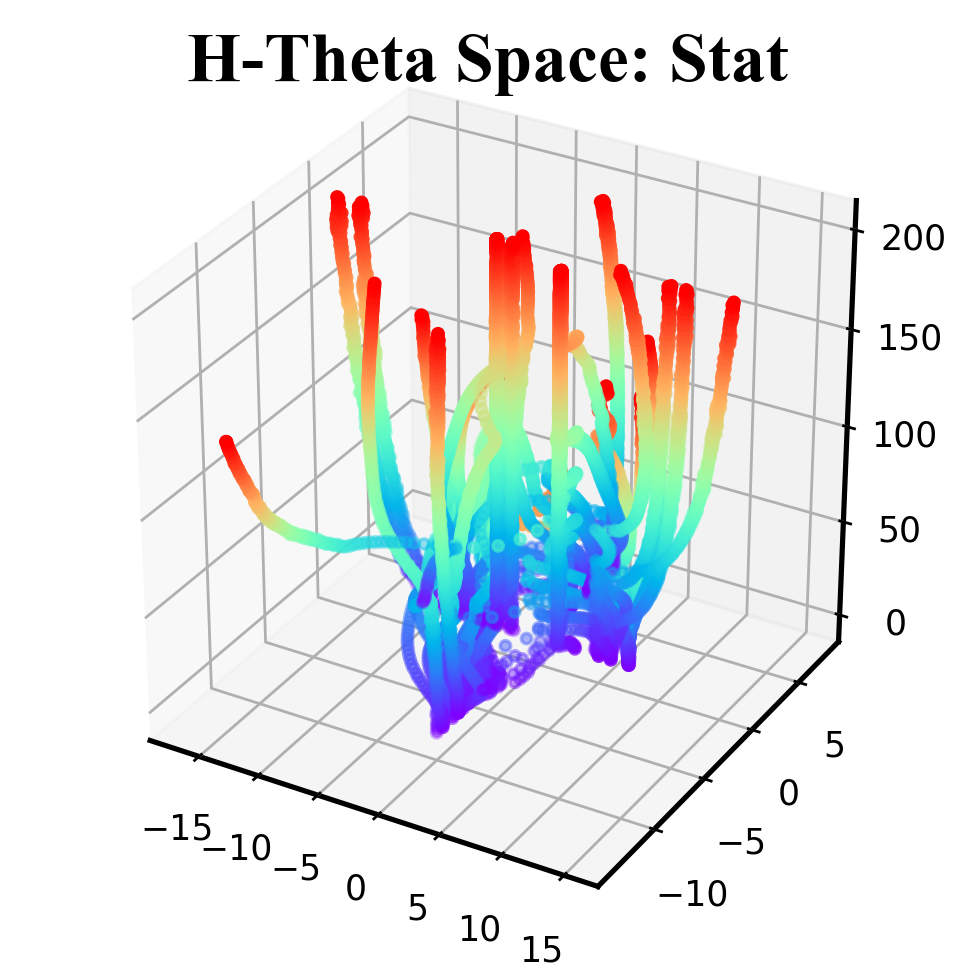

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.0.0 (clang-900.0.39.2)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --arch=x86_64 --enable-x86asm --enable-libx265 --enable-gpl --enable-postproc --enable-libx264 --enable-libxvid
  libavutil      56. 14.100

In [15]:
#For each Reynolds number (aka Swim Direction)
%matplotlib inline
def PlotAllHTheta(data,name):
    #global figAll,axAll

    #Figure with every pt for each Re
    csfont = {'fontname':'Times New Roman'}
    figAll = plt.figure(num=1,figsize=(4,4),dpi=250)
    #figAll, axAll = plt.subplots(nrows=1, ncols=1,num=0,figsize=(16,16),dpi=250)
    axAll = figAll.add_subplot(111,projection='3d')
    axAll.set_title('H-Theta Space: '+name,fontsize=20,**csfont)
    #axAll.set_xlabel(r'$\Theta/\pi$',fontsize=18,**csfont)
    #axAll.set_ylabel('H/R\tR=2.0mm',fontsize=18,**csfont)
    
    #print('data length = ',len(data))
    for idx in range(len(data)):
        #print('idx = ',idx)
        tempData = data[idx].copy()
        H = tempData['H']/RADIUSLARGE
        Theta = tempData['Theta']
        dH = tempData['dH']/RADIUSLARGE
        dTheta = tempData['dTheta']
        time = tempData['time']/PERIOD
        #GENERATE FIGURE
        X = H*np.cos(Theta)
        Y = H*np.sin(Theta)
        #print('Theta = ',Theta[0])
        #if(np.amax(H) <= 10.0):
        axAll.scatter(X,Y,time,c=time,cmap='rainbow',s=9)

        #axAll.set_ylim(0.0,np.amax(H)/RADIUSLARGE) #[Theta,H/RADIUSLARGE],
        #ax.set_xlim(90.0*np.pi/180.0,270.0*np.pi/180.0)
        #SetAxesParameters(ax,-0.05,0.05,0.02,0.01,0.01)
    #axAll.set_ylim(0.0,10.0)
    figAll.tight_layout()
    plt.show()
    # rotate the axes and update
    count = 0
    for ii in range(0,360,1):
        axAll.view_init(elev=10., azim=ii)
        figName = cwd_PYTHON + '/../HThetaPlots/Periodic/Rotated/'+name+'/Rotate_'+name
        figAll.savefig(figName+'_%03d.png' % count)
        count += 1
    #figAll.savefig(cwd_PYTHON + '/../HThetaPlots/Periodic/HThetaAll_Cyl_'+name+'.png')
    figAll.clf()
    plt.close()
    #print('About to exit PlotAll')

    return

#For each Reynolds number (aka Swim Direction)
for idxRe in range(len(SwimDirList)):
    PlotAllHTheta(allData[idxRe],SwimDirList[idxRe])
    #Make a Movie!
    os.chdir(cwd_PYTHON + '/../HThetaPlots/Periodic/Rotated/'+SwimDirList[idxRe]+'/')
    if(idxRe == 0):
        !pwd
        !ffmpeg -r 30 -i Rotate_SSL_%03d.png -vcodec libx264 -pix_fmt yuv420p -y Rotated_SSL.mp4
    elif(idxRe == 1):
        !ffmpeg -r 30 -i Rotate_LSL_%03d.png -vcodec libx264 -pix_fmt yuv420p -y Rotated_LSL.mp4
    elif(idxRe == 2):
        !ffmpeg -r 30 -i Rotate_Stat_%03d.png -vcodec libx264 -pix_fmt yuv420p -y Rotated_Stat.mp4
    os.chdir(cwd_PYTHON)


data length =  74


/Users/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


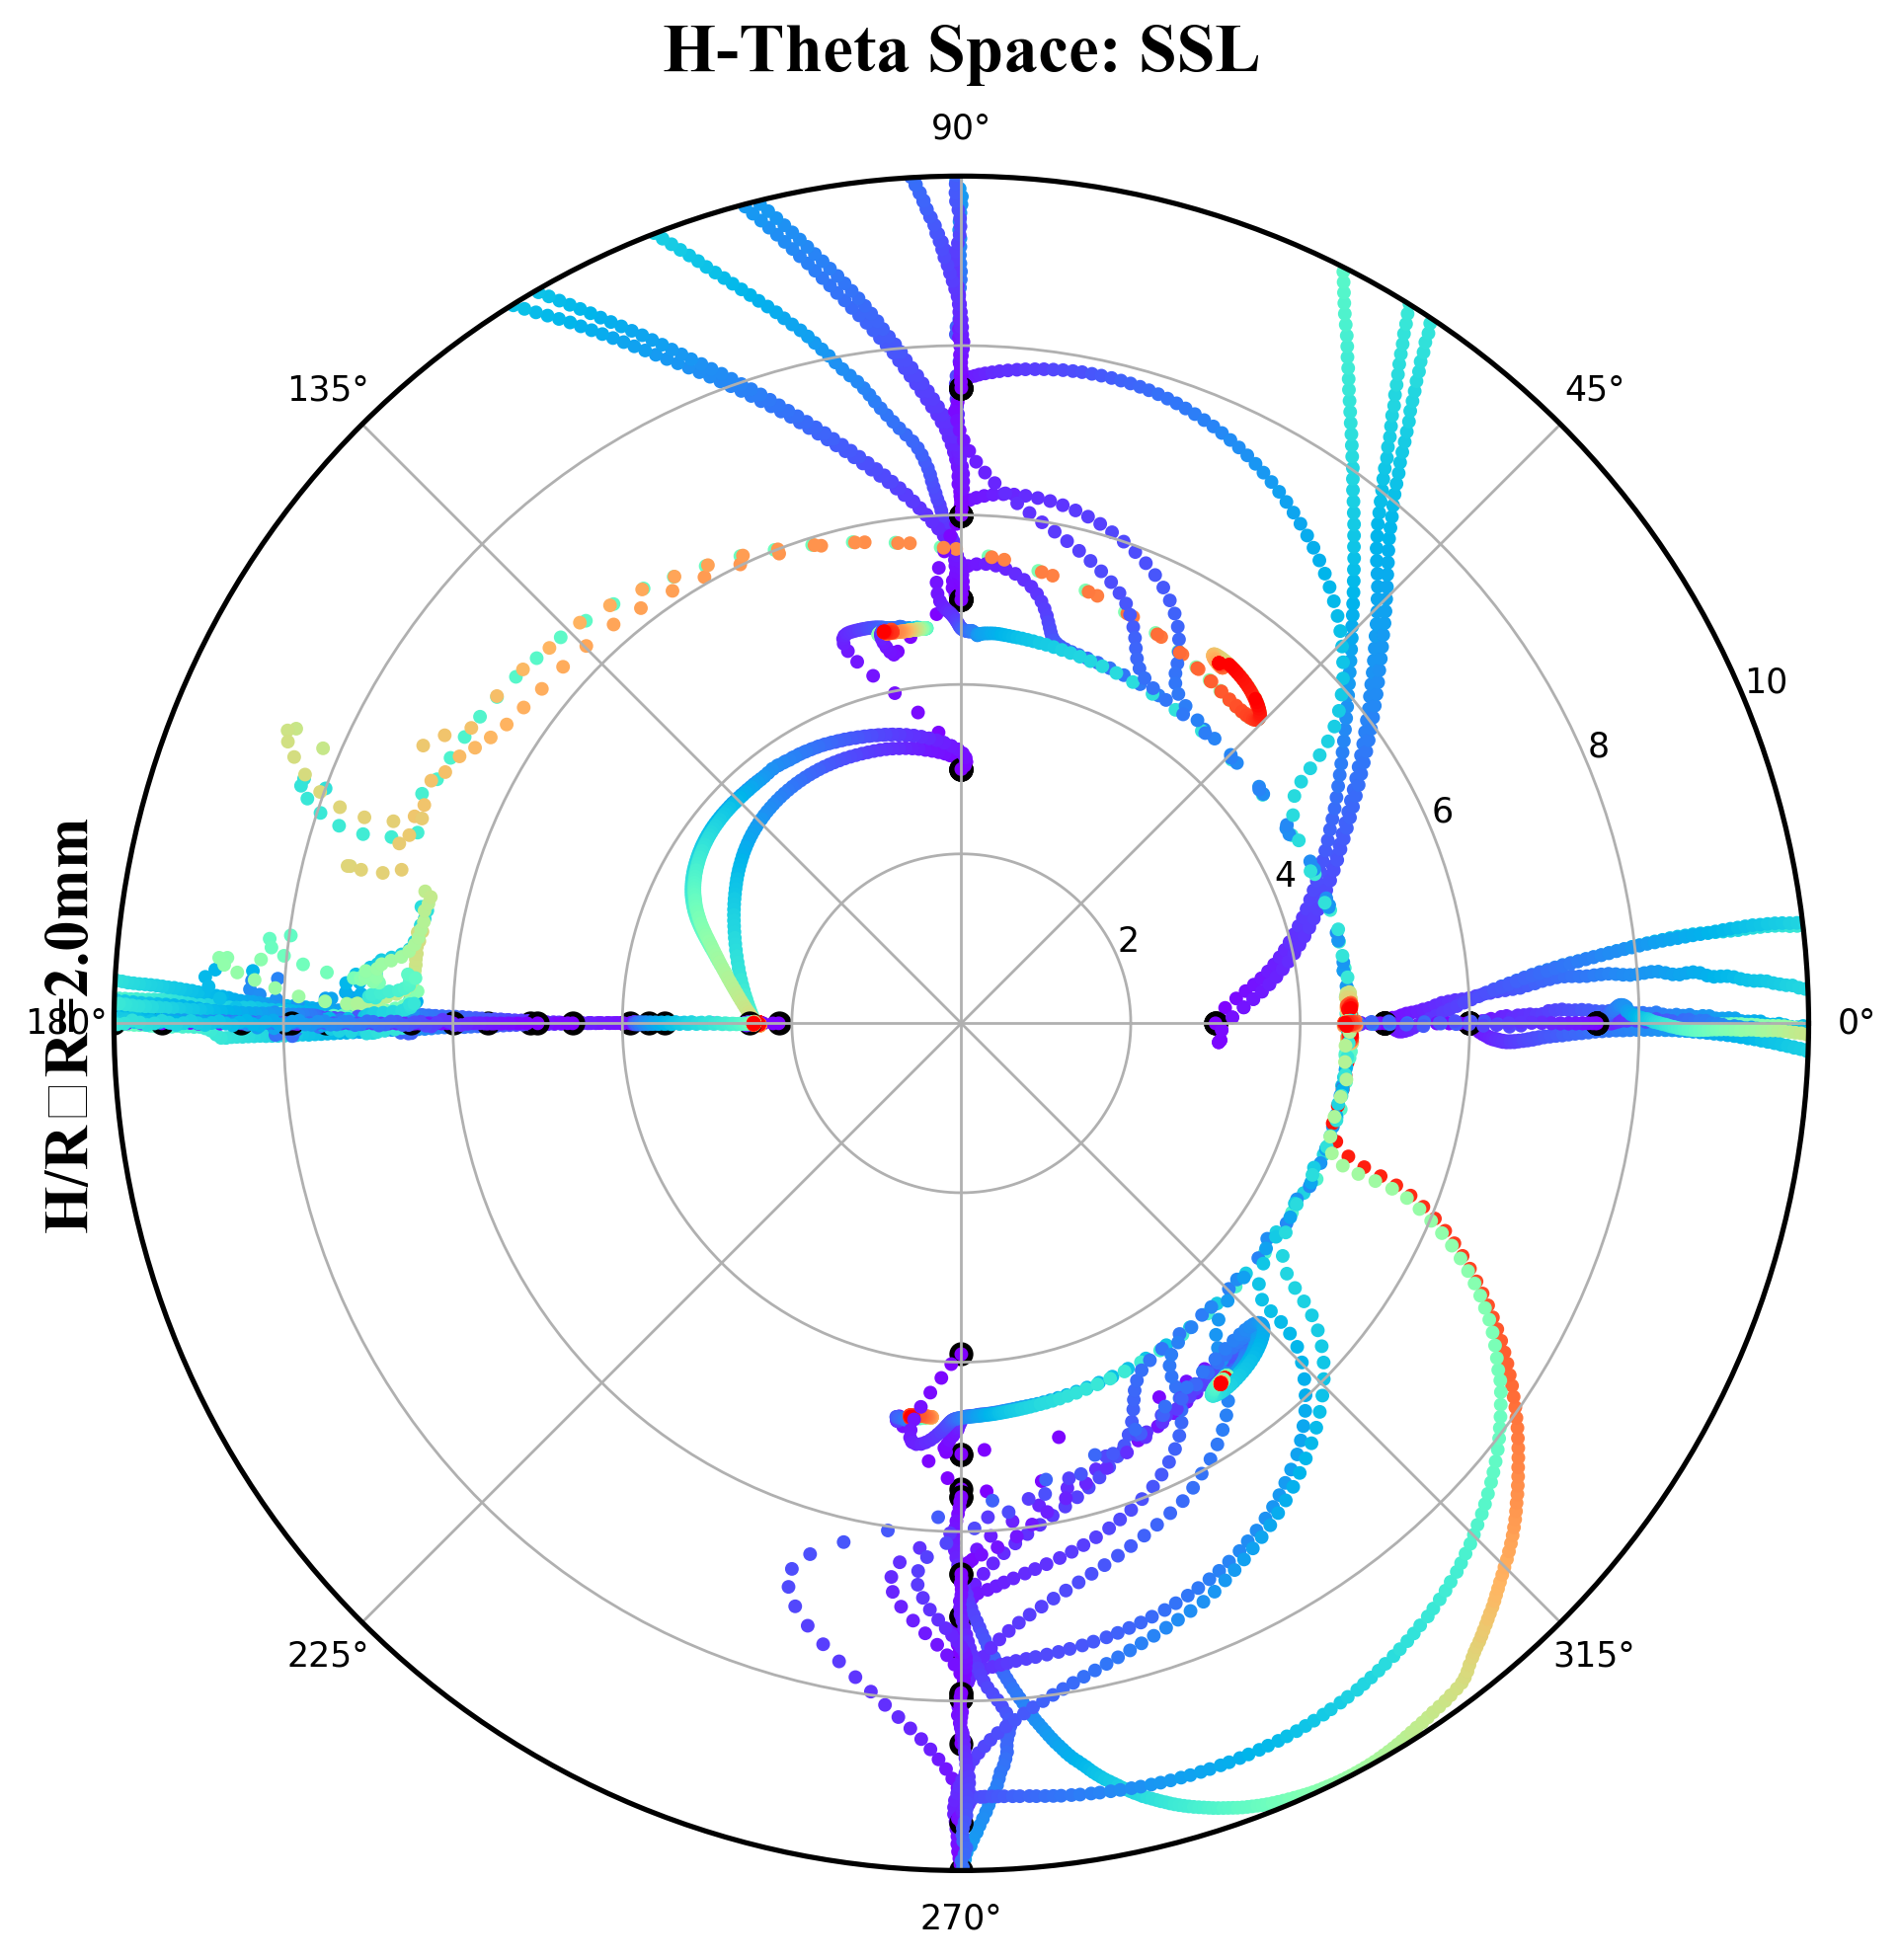

About to exit PlotAll
data length =  74


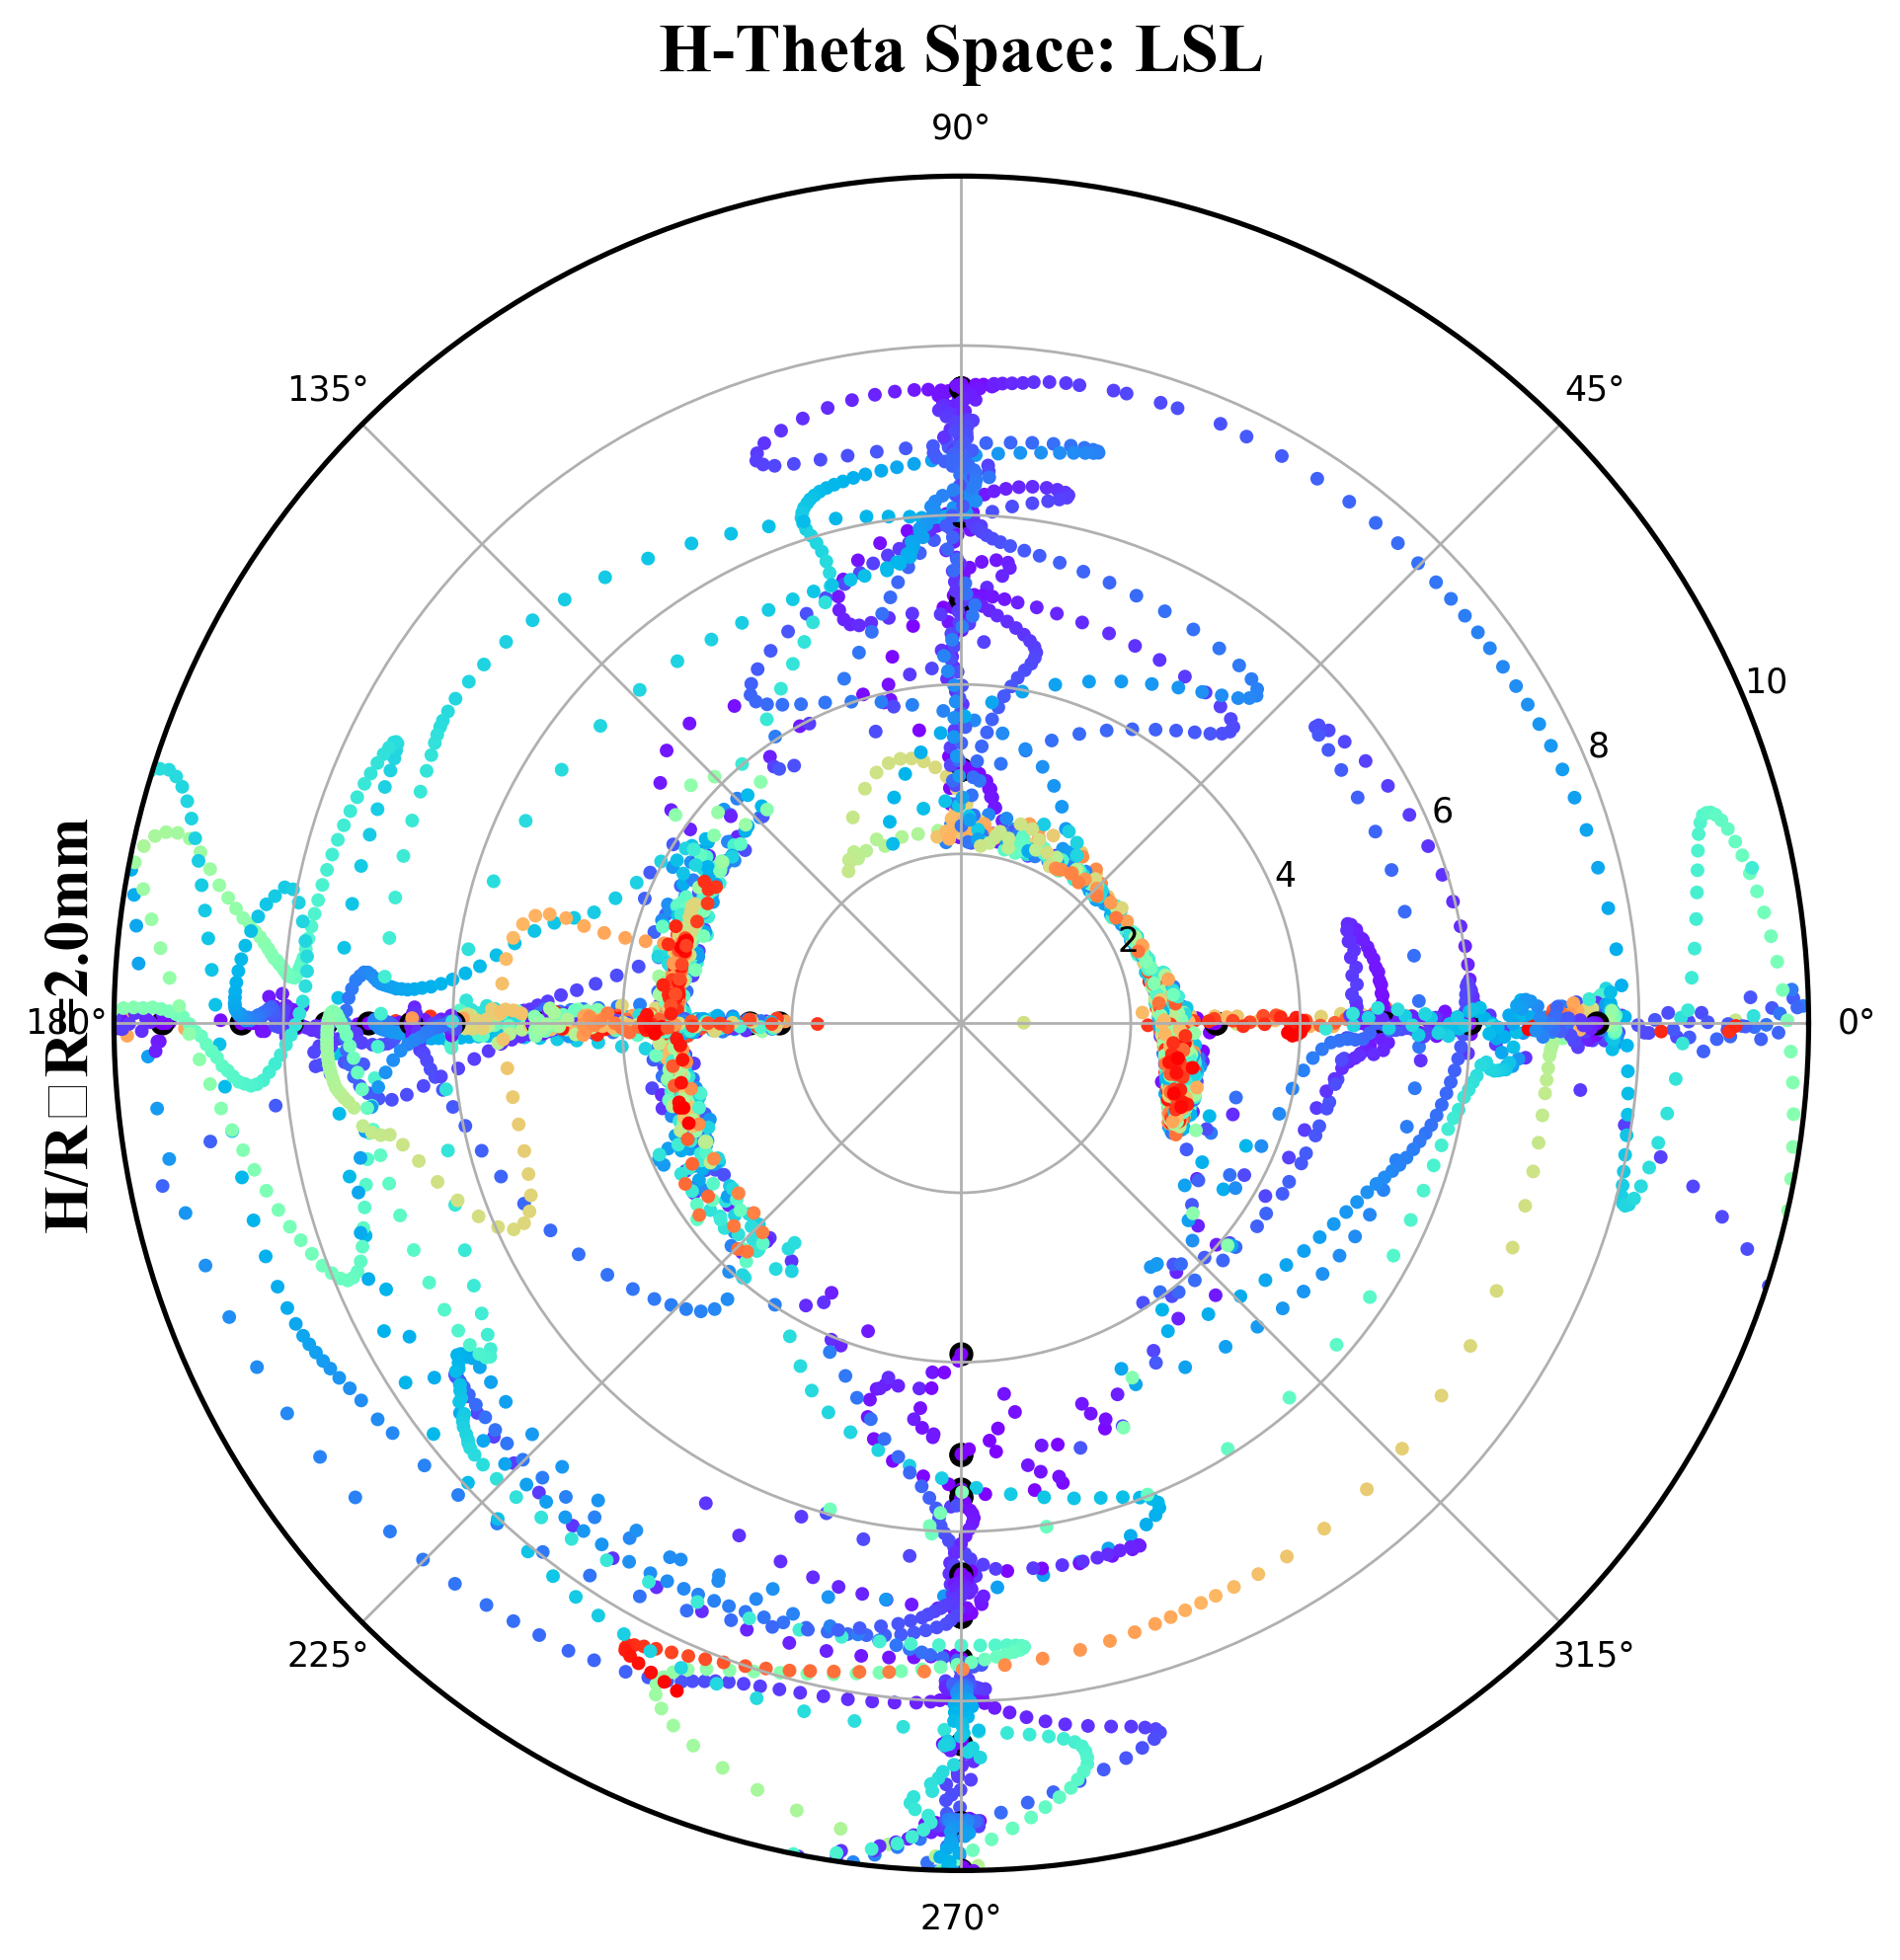

About to exit PlotAll
data length =  74


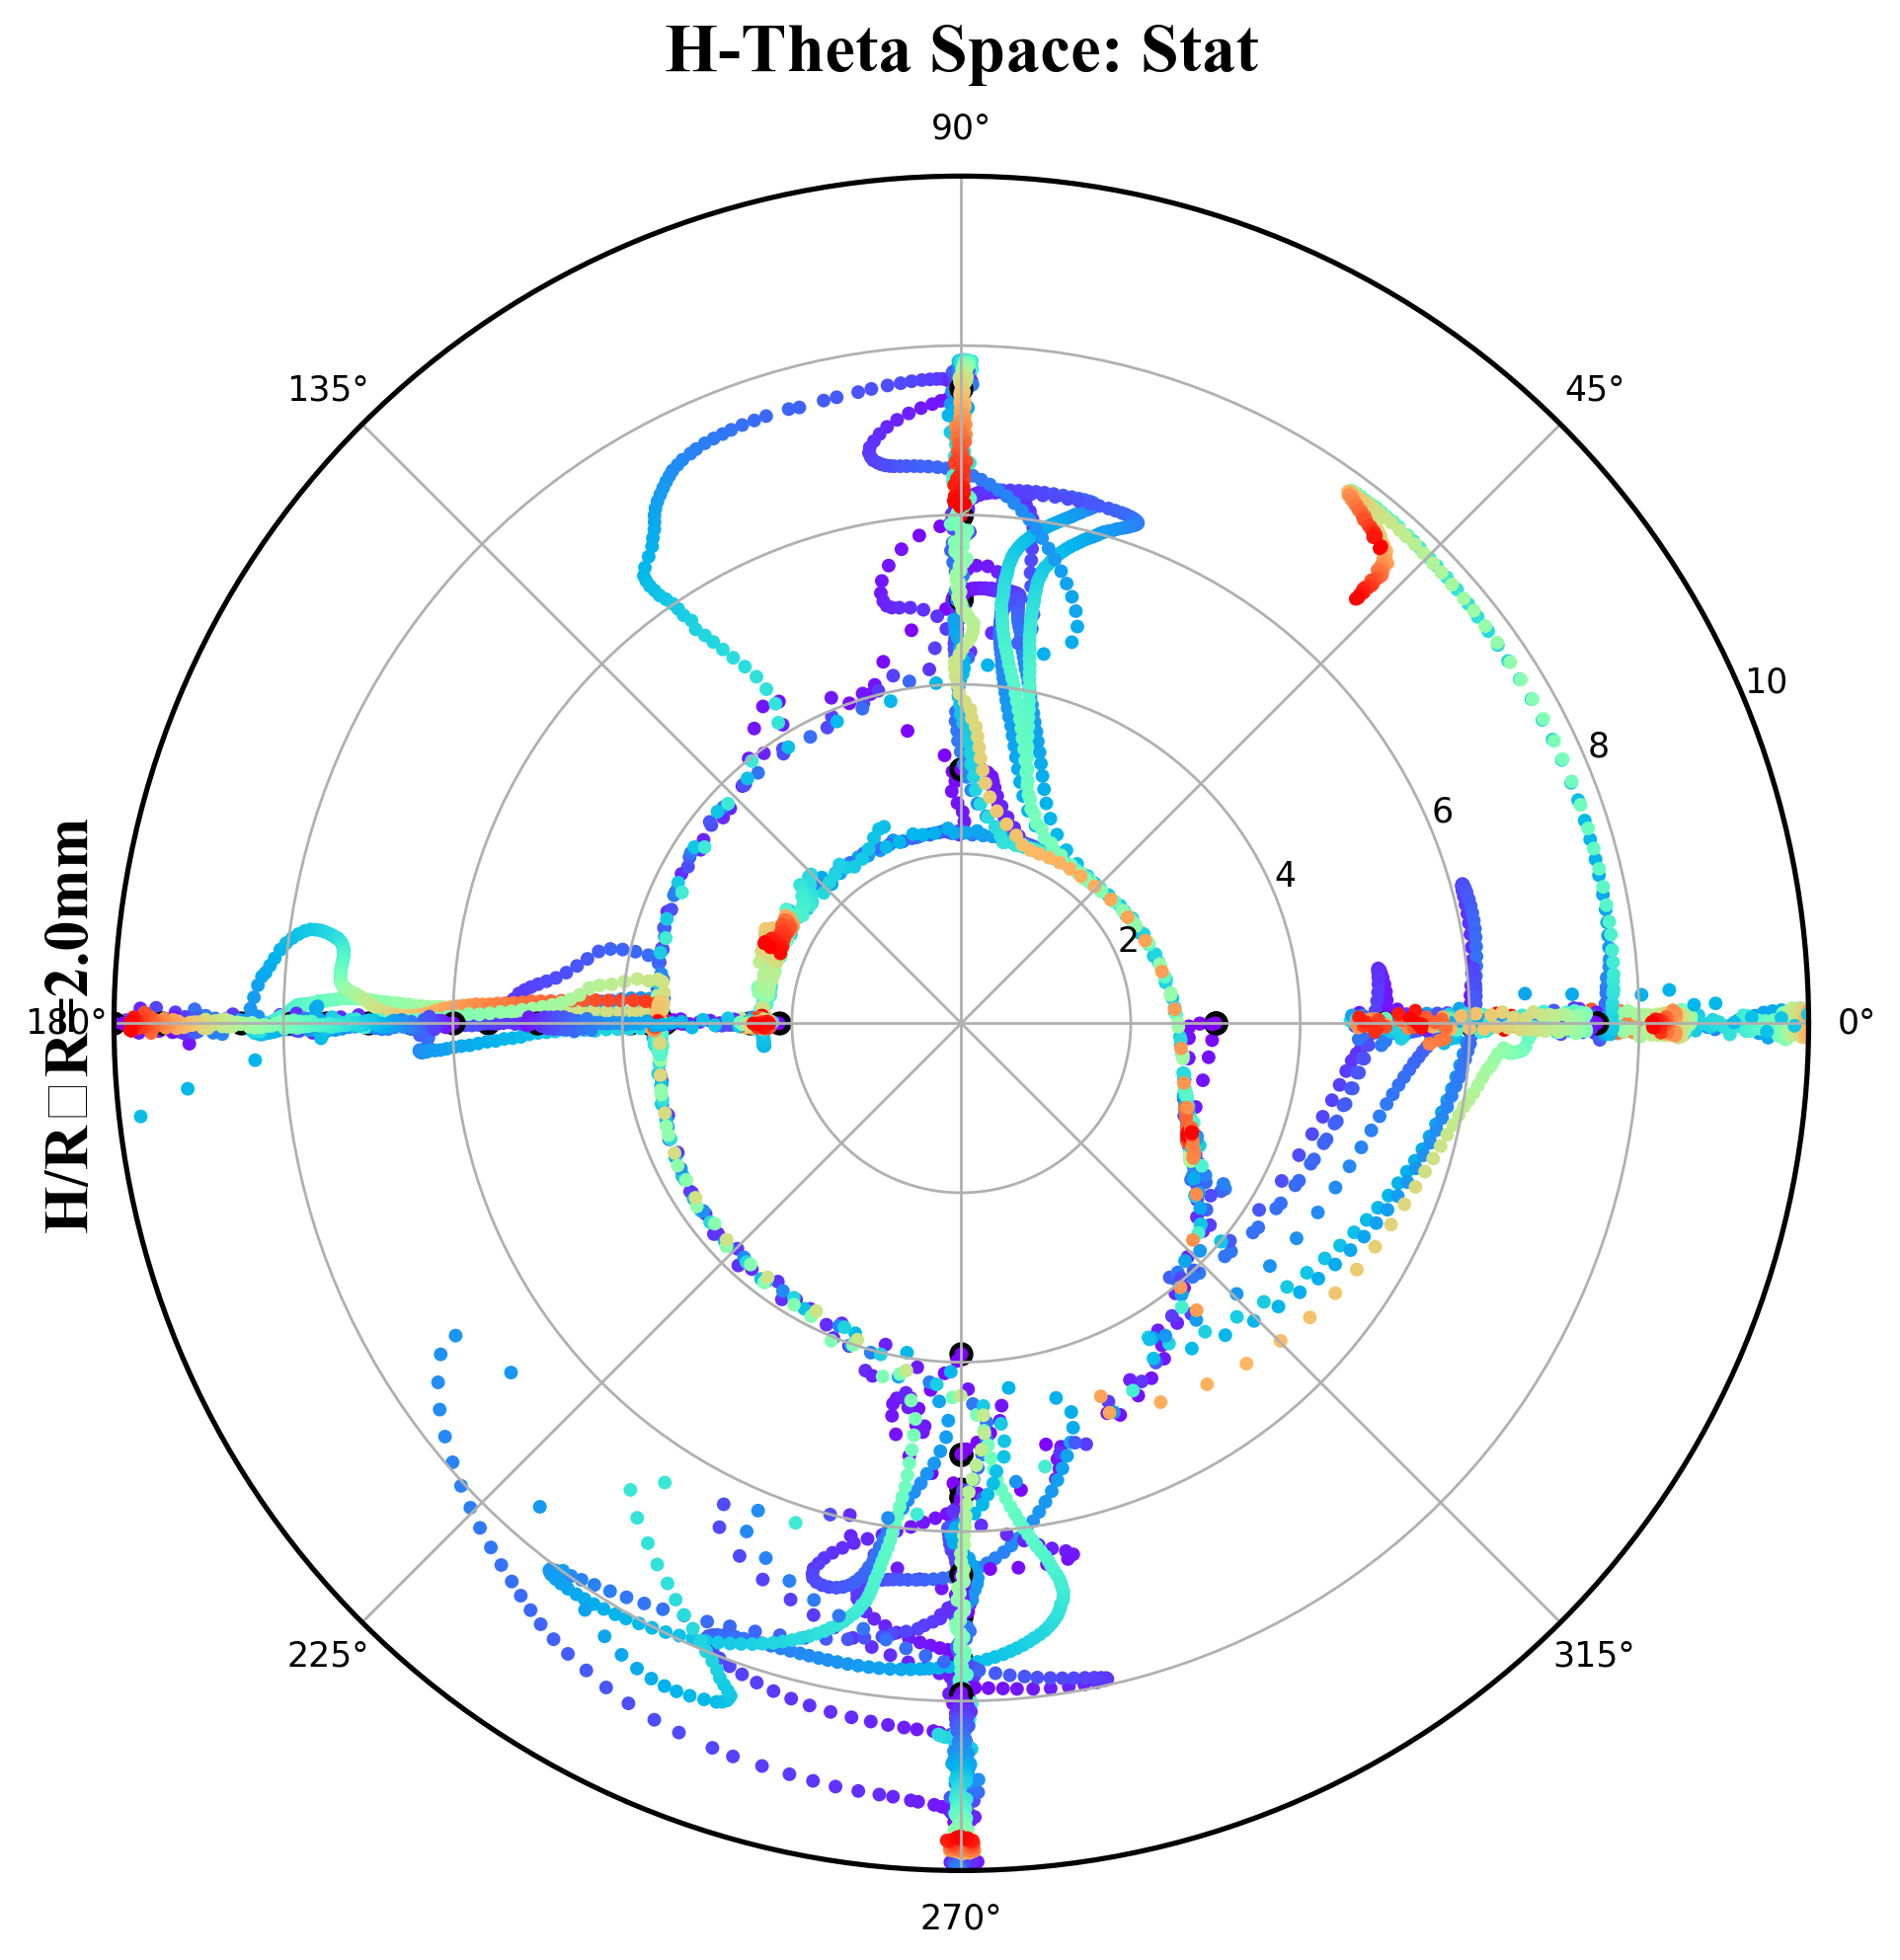

About to exit PlotAll


In [16]:
def PlotAllHThetaPolar(data,name):
    #global figAll,axAll

    #Figure with every pt for each Re
    csfont = {'fontname':'Times New Roman'}
    figAll = plt.figure(num=1,figsize=(8,8),dpi=250)
    #figAll, axAll = plt.subplots(nrows=1, ncols=1,num=0,figsize=(16,16),dpi=250)
    axAll = figAll.add_subplot(111,projection='polar')
    axAll.set_title('H-Theta Space: '+name,fontsize=20,**csfont)
    #axAll.set_xlabel(r'$\Theta/\pi$',fontsize=18,**csfont)
    axAll.set_ylabel('H/R\tR=2.0mm',fontsize=18,**csfont)
    
    print('data length = ',len(data))
    for idx in range(len(data)):
        #print('idx = ',idx)
        tempData = data[idx].copy()
        H = tempData['H']/RADIUSLARGE
        Theta = tempData['Theta']
        dH = tempData['dH']/RADIUSLARGE
        dTheta = tempData['dTheta']
        time = tempData['time']
        #GENERATE FIGURE
        #print('Theta = ',Theta[0])
        axAll.scatter(Theta[0],H[0],c='k')
        '''if(H[len(H)-1] <= 10.0):
            if(Theta[len(Theta)-1] <= np.pi/2.0):
                axAll.plot([Theta[0],Theta[len(Theta)-1]],[H[0],H[len(H)-1]],c='b')
                axAll.scatter(Theta[len(Theta)-1],H[len(H)-1],c='b')
            elif(Theta[len(Theta)-1] <= np.pi and Theta[len(Theta)-1] > np.pi/2.0):
                axAll.plot([Theta[0],Theta[len(Theta)-1]],[H[0],H[len(H)-1]],c='g')
                axAll.scatter(Theta[len(Theta)-1],H[len(H)-1],c='g')
            elif(Theta[len(Theta)-1] <= 3.0*np.pi/2.0 and Theta[len(Theta)-1] > np.pi):
                axAll.plot([Theta[0],Theta[len(Theta)-1]],[H[0],H[len(H)-1]],c='r')
                axAll.scatter(Theta[len(Theta)-1],H[len(H)-1],c='r')
            else:
                axAll.plot([Theta[0],Theta[len(Theta)-1]],[H[0],H[len(H)-1]],c='orange')
                axAll.scatter(Theta[len(Theta)-1],H[len(H)-1],c='orange')
            
            #axAll.plot([Theta[0],Theta[len(Theta)-1]],[H[0],H[len(H)-1]],c='b')
            #axAll.scatter(Theta[len(Theta)-1],H[len(H)-1],c='r')
        '''
        axAll.scatter(Theta,H,c=time,cmap='rainbow',s=9)
        #Create Mesh of Delta H and Theta
        mTheta, mH = np.meshgrid(Theta,H)
        mdTheta, mdH = np.meshgrid(dTheta,dH)
        normdH, normdTheta = mdH/np.hypot(mdH,mdTheta), mdTheta/np.hypot(mdH,mdTheta)
        #Plot Chnages in H and Theta in quiver plot (Vec Field)
        '''
        for idx in range(0,len(Theta),10):
            #Polar
            
            axAll.quiver(mTheta[idx,idx],mH[idx,idx],
                          normdH[idx,idx]*np.cos(mTheta[idx,idx])-normdTheta[idx,idx]*np.sin(mTheta[idx,idx]),
                          normdH[idx,idx]*np.sin(mTheta[idx,idx])+normdTheta[idx,idx]*np.cos(mTheta[idx,idx]),
                          color='k',scale=25,headwidth=3,minshaft=2)
            
            
            
            axAll.quiver(mTheta[idx,idx],mH[idx,idx],
                          mdH[idx,idx]*np.cos(mTheta[idx,idx])-mdTheta[idx,idx]*np.sin(mTheta[idx,idx]),
                          mdH[idx,idx]*np.sin(mTheta[idx,idx])+mdTheta[idx,idx]*np.cos(mTheta[idx,idx]),
                          color='k',scale=25,headwidth=3,minshaft=2)
            
        
            #Cartesian
            axAll.quiver(mTheta[idx,idx],mH[idx,idx],
                          normdTheta[idx,idx],normdH[idx,idx],
                          color='k',scale=25,headwidth=3,minshaft=2)
        '''
        #print('Theta: ',len(Theta))
        #print(Theta)
        #axAll.set_ylim(0.0,np.amax(H)/RADIUSLARGE) #[Theta,H/RADIUSLARGE],
        #ax.set_xlim(90.0*np.pi/180.0,270.0*np.pi/180.0)
        #SetAxesParameters(ax,-0.05,0.05,0.02,0.01,0.01)
    axAll.set_ylim(0.0,10.0)
    figAll.tight_layout()
    plt.show()
    #figAll.savefig(cwd_PYTHON + '/../HThetaPlots/Periodic/HThetaAll_InitLast_'+name+'.png')
    figAll.clf()
    plt.close()
    print('About to exit PlotAll')

    return

#For each Reynolds number (aka Swim Direction)
for idxRe in range(len(SwimDirList)):
    PlotAllHThetaPolar(allData[idxRe],SwimDirList[idxRe])

In [ ]:
def PlotAllHThetaPolarMovie(data,name):
    #global figAll,axAll

    #Figure with every pt for each Re
    csfont = {'fontname':'Times New Roman'}
    figAll = plt.figure(num=1,figsize=(4,4),dpi=250)
    #figAll, axAll = plt.subplots(nrows=1, ncols=1,num=0,figsize=(16,16),dpi=250)
    
    #Data is from each sim
    #Need to figure out a way to get the zeroth timestep value of each simulation
    #Then I need to do this for all timesteps
    #First I need to concatenate all the data...
    #Then I need to sort by time
    #Then I choose a loop over time values and plot them all
    
    everyDict = {'Theta':[],'H':[],'time':[]}
    everyData = pd.DataFrame(data=everyDict)
    for idx in range(len(data)):
        #If simulation ended before 20s, add last timestep pts till 20s
        tempData = data[idx].copy()
        nTime = len(tempData['time'])
        if(201 - nTime > 0):
            #Sim ended early
            count = 201 - nTime
            for idxCount in range(count):
                tempData.loc[nTime+count,'H'] = tempData.loc[nTime-1,'H']
                tempData.loc[nTime+count,'Theta'] = tempData.loc[nTime-1,'Theta']
                tempData.loc[nTime+count,'time'] = tempData.loc[nTime-1,'time']+(count+1)*PERIOD
        everyData = pd.concat([everyData,tempData],ignore_index=True)
    everyData.sort_values(by=['time'])
    everyData.reset_index(drop=True)
    
    for idxTime in range(201):
        #print('idxTime = ',idxTime)
        axAll = figAll.add_subplot(111,projection='polar')
        axAll.set_title('H-Theta Space: '+name,fontsize=16,**csfont)
        #axAll.set_xlabel(r'$\Theta/\pi$',fontsize=18,**csfont)
        axAll.set_ylabel('H/R\tR=2.0mm',fontsize=12,**csfont)
        timeValue = idxTime*PERIOD
        initData = everyData[everyData['time'] == 0.0].copy()
        tempData = everyData[everyData['time'] <= timeValue+0.001].copy()
        tempData = tempData[tempData['time'] >= timeValue - 0.001].copy()
        H = tempData['H']/RADIUSLARGE
        Theta = tempData['Theta']
        dH = tempData['dH']/RADIUSLARGE
        dTheta = tempData['dTheta']
        time = tempData['time']
        #GENERATE FIGURE
        if(timeValue == 0.0):
            axAll.scatter(initData['Theta'],initData['H']/RADIUSLARGE,c='k',s=9)
        if(timeValue != 0.0):
            axAll.scatter(Theta,H,c=H,cmap='rainbow',s=9)
        axAll.set_ylim(0.0,0.5*np.amax(everyData['H']/RADIUSLARGE))
        figAll.tight_layout()
        figName = cwd_PYTHON + '/../HThetaPlots/Periodic/PolarMovie/'+name+'/PolarMovie_'+name
        figAll.savefig(figName+'_%03d.png' % idxTime)
        figAll.clf()
        
    plt.close()
    print('About to exit PlotAll')

    return

#For each Reynolds number (aka Swim Direction)
for idxRe in range(len(SwimDirList)):
    PlotAllHThetaPolarMovie(allData[idxRe],SwimDirList[idxRe])
    #Make a Movie!
    os.chdir(cwd_PYTHON + '/../HThetaPlots/Periodic/PolarMovie/'+SwimDirList[idxRe]+'/')
    if(idxRe == 0):
        !pwd
        !ffmpeg -r 15 -i PolarMovie_SSL_%03d.png -vcodec libx264 -pix_fmt yuv420p -y PolarMovie_SSL.mp4
    elif(idxRe == 1):
        !ffmpeg -r 15 -i PolarMovie_LSL_%03d.png -vcodec libx264 -pix_fmt yuv420p -y PolarMovie_LSL.mp4
    elif(idxRe == 2):
        !ffmpeg -r 15 -i PolarMovie_Stat_%03d.png -vcodec libx264 -pix_fmt yuv420p -y PolarMovie_Stat.mp4
    os.chdir(cwd_PYTHON)

In [17]:
from IPython.display import Video
os.chdir(cwd_PYTHON)
#os.chdir(cwd_PYTHON+'/../HThetaPlots/Periodic/Rotated/LSL/')
# run this before calling Video()
! ln -sf "/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/Rotated/LSL/Rotated_LSL.mp4" ./Rotated_LSL.mp4
Video('Rotated_LSL.mp4')


In [18]:
os.chdir(cwd_PYTHON)
#os.chdir(cwd_PYTHON+'/../HThetaPlots/Periodic/Rotated/LSL/')
# run this before calling Video()
! ln -sf "/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/Rotated/SSL/Rotated_SSL.mp4" ./Rotated_SSL.mp4
Video('Rotated_SSL.mp4')

In [19]:
os.chdir(cwd_PYTHON)
#os.chdir(cwd_PYTHON+'/../HThetaPlots/Periodic/Rotated/LSL/')
# run this before calling Video()
! ln -sf "/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/Rotated/Stat/Rotated_Stat.mp4" ./Rotated_Stat.mp4
Video('Rotated_Stat.mp4')

In [20]:
os.chdir(cwd_PYTHON)
#os.chdir(cwd_PYTHON+'/../HThetaPlots/Periodic/Rotated/LSL/')
# run this before calling Video()
! ln -sf "/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/PolarMovie/SSL/PolarMovie_SSL.mp4" ./PolarMovie_SSL.mp4
Video('PolarMovie_SSL.mp4')

In [21]:
os.chdir(cwd_PYTHON)
#os.chdir(cwd_PYTHON+'/../HThetaPlots/Periodic/Rotated/LSL/')
# run this before calling Video()
! ln -sf "/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/PolarMovie/Stat/PolarMovie_Stat.mp4" ./PolarMovie_Stat.mp4
Video('PolarMovie_Stat.mp4')

In [22]:
os.chdir(cwd_PYTHON)
#os.chdir(cwd_PYTHON+'/../HThetaPlots/Periodic/Rotated/LSL/')
# run this before calling Video()
! ln -sf "/Users/thomas/sfw/Paper/PairWise/PosData/HThetaPlots/Periodic/PolarMovie/LSL/PolarMovie_LSL.mp4" ./PolarMovie_LSL.mp4
Video('PolarMovie_LSL.mp4')